### Context
The original dataset contains 1000 entries with 20 categorical/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes credit from a bank. Each person is classified as good or bad credit risks according to the set of attributes. It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, the attributes in this dataset are a subset of the original dataset. Several columns are simply ignored, and some of the important attributes like age, account balance, etc. are retained.

### Objective 
The objective is to build a model to predict whether a person would default or not.

### Dataset:
- Age (Numeric: Age in years)
- Sex (Categories: male, female)
- Job (Categories: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (Categories: own, rent, or free)
- Saving accounts (Categories: little, moderate, quite rich, rich)
- Checking account (Categories: little, moderate, rich)
- Credit amount (Numeric: Amount of credit in DM - Deutsche Mark)
- Duration (Numeric : Duration for which the credit is given in months)
- Purpose (Categories: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
- Risk (0 - Person is not at risk, 1 - Person is at risk(defaulter))

## Let's start by importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

## Load and overview the dataset

In [2]:
# Loading the dataset - sheet_name parameter is used if there are multiple tabs in the excel file.
data = pd.read_csv("German_Credit.csv")

In [3]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1


### Understand the shape of the dataset.

In [4]:
data.shape

(1000, 10)

### Check the data types of the columns for the dataset.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


- There are total 10 columns and 1,000 observations in the dataset

- We can see that 2 columns have less than 1,000 non-null values i.e. columns have missing values.

In [6]:
# Risk should be a categorical variable
data["Risk"] = data["Risk"].astype("category")

### Check and treat for missing values

In [7]:
pd.DataFrame(
    data={
        "% of Missing Values": round(data.isna().sum() / data.isna().count() * 100, 2)
    }
)

,% of Missing Values
Age,0.0
Sex,0.0
Job,0.0
Housing,0.0
Saving accounts,18.3
Checking account,39.4
Credit amount,0.0
Duration,0.0
Purpose,0.0
Risk,0.0


* We can see that two columns - 'Saving accounts' and 'Checking account' have 18% and 39% missing values respectively.
* We can either drop these columns or drop rows with missing values but then we would lose data for such a small dataset.
* As both of these columns are categorical, we can treat those missng values as a new category.

In [8]:
data['Saving accounts'].fillna(value='unknown',inplace=True)
data['Checking account'].fillna(value='unknown',inplace=True)
data.isna().sum()/len(data.isna())

Age                 0.0
Sex                 0.0
Job                 0.0
Housing             0.0
Saving accounts     0.0
Checking account    0.0
Credit amount       0.0
Duration            0.0
Purpose             0.0
Risk                0.0
dtype: float64

**Let's check the number of unique values in each column**

In [9]:
data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       5
Checking account      4
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

- Age has only 53 unique values i.e. most of the customers are of similar age
- We have only three continuous variables - Age, Credit Amount and Duration.
- All other variables are categorical

**Checking the value count for each category of categorical variables** 

In [10]:
# Making a list of all catrgorical variables
cat_col = [
    "Sex",
    "Job",
    "Housing",
    "Saving accounts",
    "Checking account",
    "Purpose",
    "Risk",
]

# Printing number of count of each unique value in each column
for column in cat_col:
    print(data[column].value_counts())
    print("-" * 40)

male      690
female    310
Name: Sex, dtype: int64
----------------------------------------
2    630
1    200
3    148
0     22
Name: Job, dtype: int64
----------------------------------------
own     713
rent    179
free    108
Name: Housing, dtype: int64
----------------------------------------
little        603
unknown       183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
----------------------------------------
unknown     394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64
----------------------------------------
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64
----------------------------------------
0    700
1    300
Name: Risk, dtype: int64
----------------------------------------


- We have more male customers as compared to female customers
- There are very few observations i.e. only 22 for customers with job category - unskilled and non-resident
- We can see that the distribution of classes in the target variable is imbalanced i.e. only 30% observations with defaulters.

**Summary of the data**

In [11]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1000.0,NaN,NaN,NaN,35.546,11.375469,19.0,27.0,33.0,42.0,75.0
Sex,1000,2,male,690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Job,1000.0,NaN,NaN,NaN,1.904,0.653614,0.0,2.0,2.0,2.0,3.0
Housing,1000,3,own,713,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saving accounts,1000,5,little,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Checking account,1000,4,unknown,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit amount,1000.0,NaN,NaN,NaN,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,NaN,NaN,NaN,20.903,12.058814,4.0,12.0,18.0,24.0,72.0
Purpose,1000,8,car,337,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Risk,1000.0,2.0,0.0,700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Observations**

- Mean value for the age column is approx 35 and median is 33. This shows that majority of the customers are under 35 years of age.
- Mean amount of credit is approx 3,271 but it has a wide range with from 250 to 18,424. We will explore this further in univariate analysis.
- Mean duration for which the credit is given is approx 21 months.
* Most of the customers are not at risk

## Univariate analysis

In [12]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical
# variable.
# This function takes the numerical column as the input and returns the boxplots
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(
        feature, kde=F, ax=ax_hist2, bins=bins, color="orange"
    ) if bins else sns.distplot(
        feature, kde=False, ax=ax_hist2, color="tab:cyan"
    )  # For histogram
    ax_hist2.axvline(
        np.mean(feature), color="purple", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        np.median(feature), color="black", linestyle="-"
    )  # Add median to the histogram

### Observation on Age 

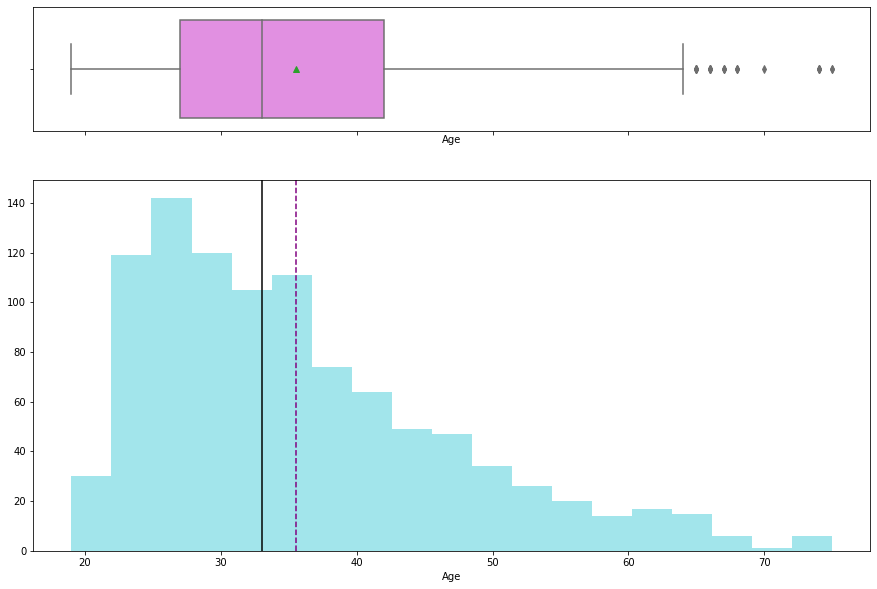

In [13]:
histogram_boxplot(data["Age"])

- The distribution of age is right skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

### Observation on Credit Amount

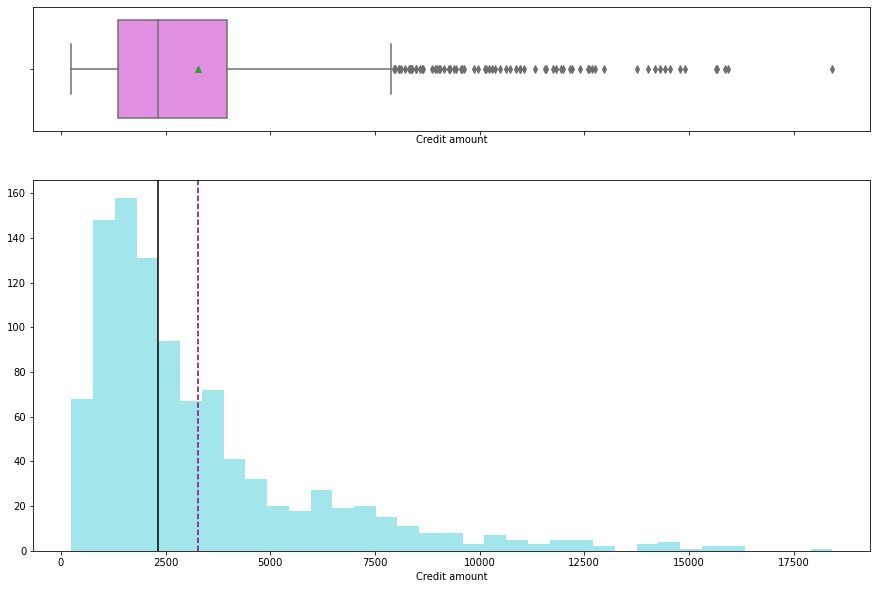

In [14]:
histogram_boxplot(data["Credit amount"])

- The distribution of the credit amount is right skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

### Observations on Duration

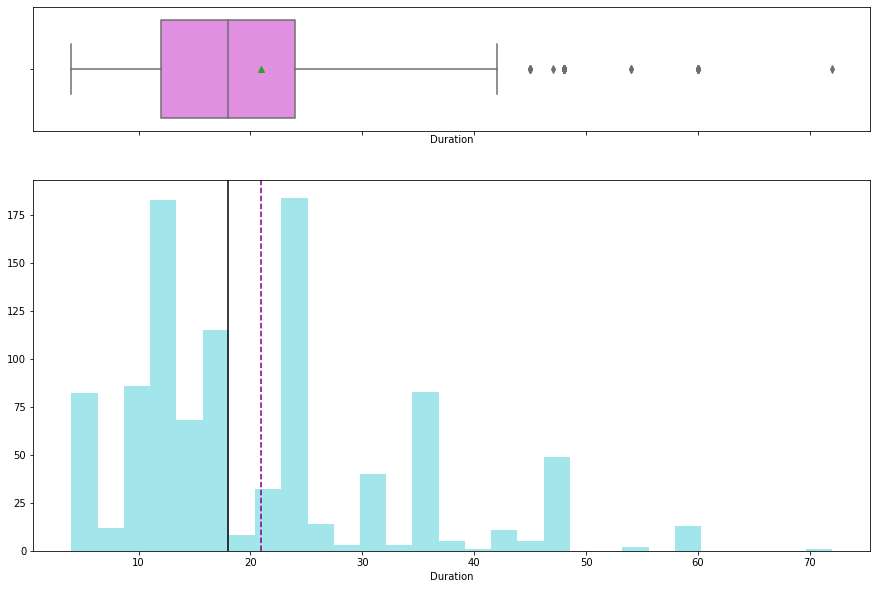

In [15]:
histogram_boxplot(data["Duration"])

- The distribution of the duration for which the credit is given is right skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

In [16]:
# Function to create barplots that indicate percentage for each category.


def perc_on_bar(plot, feature):
    """
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    """
    total = len(feature)  # length of the column
    for p in ax.patches:
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05  # width of the plot
        y = p.get_y() + p.get_height()  # hieght of the plot
        ax.annotate(percentage, (x, y), size=12)  # annotate the percantage
    plt.show()  # show the plot

### Observations on Risk

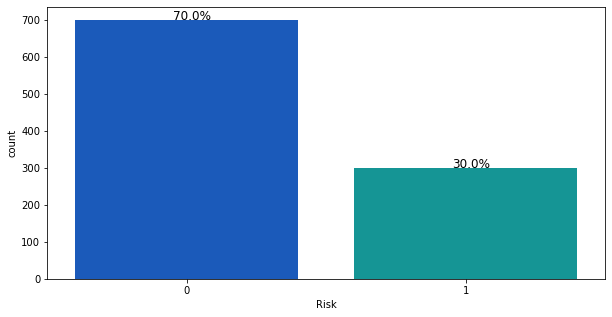

In [17]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Risk"], palette="winter")
perc_on_bar(ax, data["Risk"])

- As mentioned earlier, the class distribution in the target variable is imbalanced.
- We have 70% observations for non-defaulters and 30% observations for defaulters.

### Observations on Sex of Customers

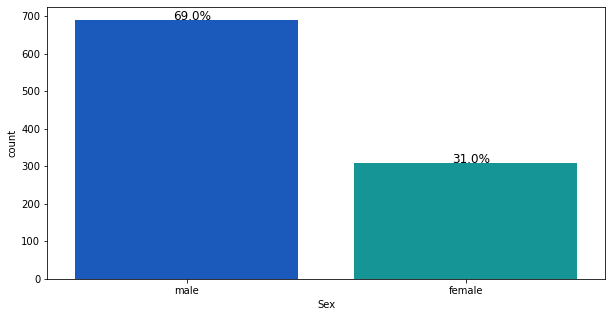

In [18]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Sex"], palette="winter")
perc_on_bar(ax, data["Sex"])

- Male customers are taking more credit than female customers
- There are approx 69% male customers and  to the female customers

### Observations on Housing

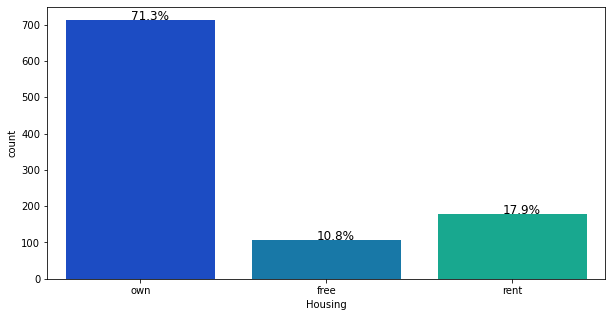

In [19]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Housing"], palette="winter")
perc_on_bar(ax, data["Housing"])

- Major of the customers, approx 71%, who take credit have there own house
- Approx 18% customers are living in a rented house
- There are only 11% customers who have a free housing. These are the customers who live in a house given by their company or organization

### Observations on Job

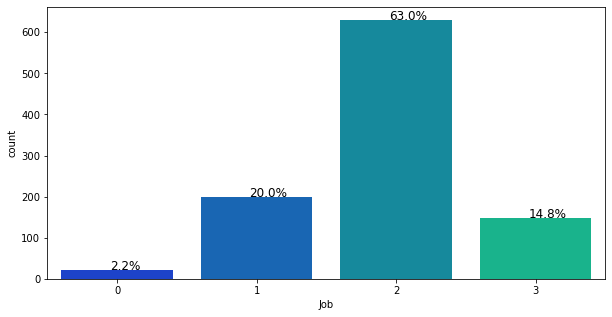

In [20]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Job"], palette="winter")
perc_on_bar(ax, data["Job"])

- Majority of the customers i.e. 63% fall into the skilled category.
- There are only approx 15% customers that lie in highly skilled category which makes sense as these may be the persons with high education or highly experienced.
- There are a very few observations, approx 22%, with 0 or 1 job category.

### Observations on Saving accounts

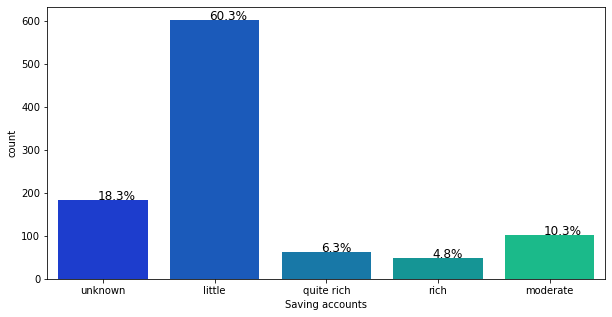

In [21]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Saving accounts"], palette="winter")
perc_on_bar(ax, data["Saving accounts"])

- Approx 70% customers who take credit have little or moderate amount in their savings account. This makes sense as these customers would need credit more than the other categories.
- Approx 11% customers who take credit are in rich category based on their balance in savings account.
- Note that the percentages do no add up to 100 as we have missing values in this column.

### Observations on Checking account

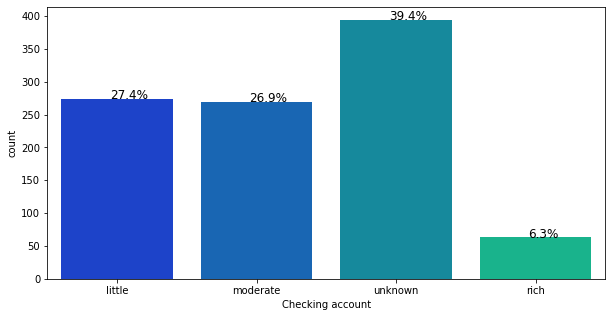

In [22]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Checking account"], palette="winter")
perc_on_bar(ax, data["Checking account"])

- Approx 54% customers who take credit have little or moderate amount in their checking account. This makes sense as these customers would need credit more than the other categories.
- Approx 6% customers who take credit are in rich category based on their balance in checking account.
- Note that the percentages do no add up to 100 as we have missing values in this column.

### Observations on Purpose

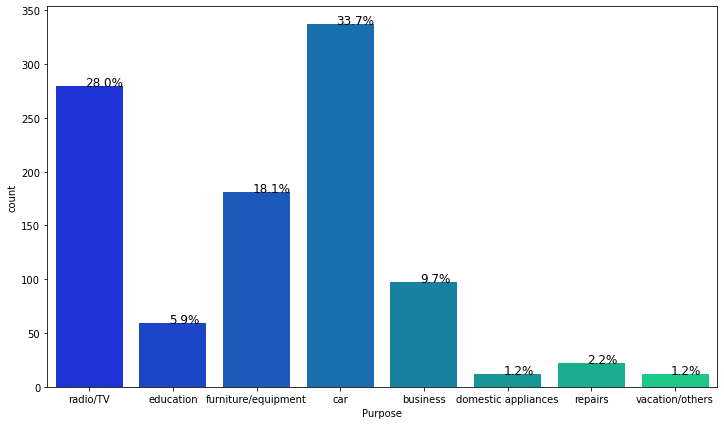

In [23]:
plt.figure(figsize=(12, 7))
ax = sns.countplot(data["Purpose"], palette="winter")
perc_on_bar(ax, data["Purpose"])

- The plot shows that most customers takes credit for luxury items like car, radio or furniture/equipment, domestic appliances.
- Approximately just 16% customers takes credit for business or education

## Bivariate Analysis

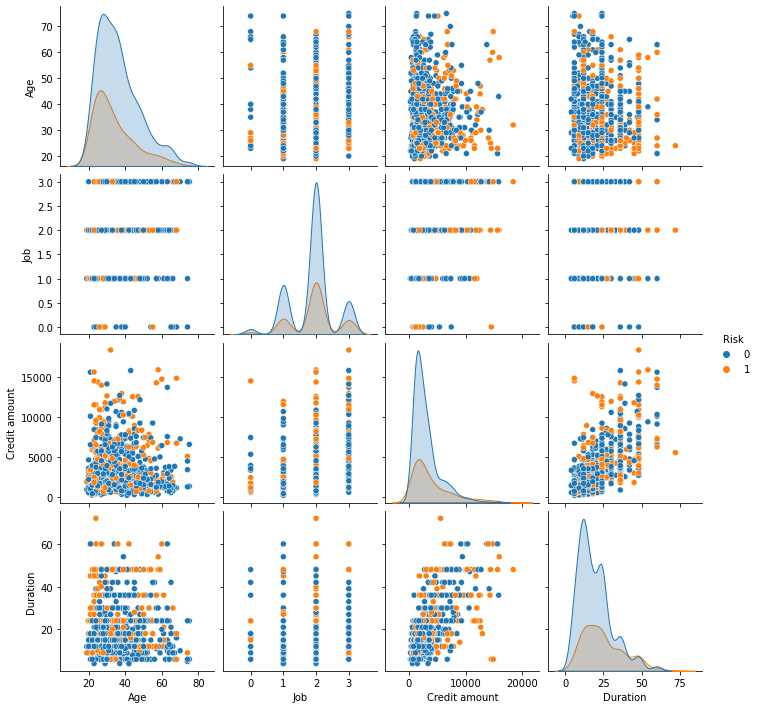

In [24]:
sns.pairplot(data, hue="Risk")
plt.show()

- There are overlaps i.e. no clear distinction in the distribution of variables for people who have defaulted and did not default.
- Let's explore this further with the help of other plots.

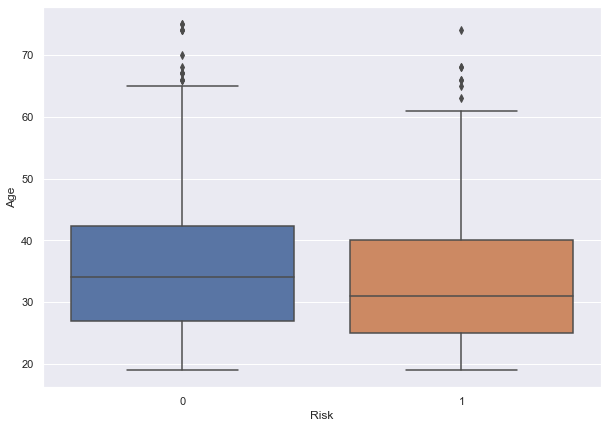

In [25]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Risk", y="Age", data=data, orient="vertical")
plt.show()

- We can see that median age of defaulters is less than median age of non-defaulters.
- This shows that younger customers are more likely to default.
- There are outliers in boxplots of both class distributions

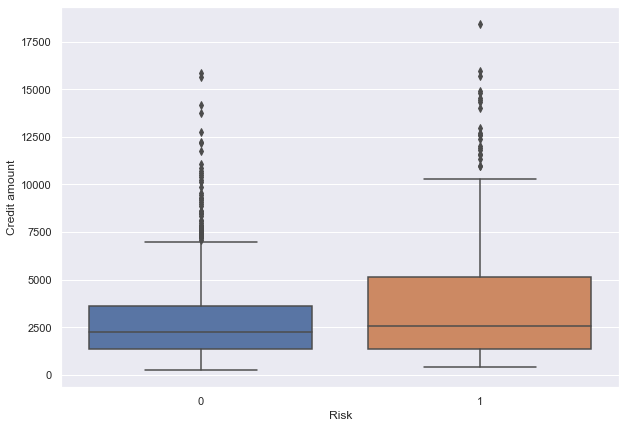

In [26]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Risk", y="Credit amount", data=data, orient="vertical")
plt.show()

- We can see that third quartile amount of defaulters is much more than the third quartile amount of non-defaulters.
- This shows that customers with high credit amount are more likely to default.
- There are outliers in boxplots of both class distributions

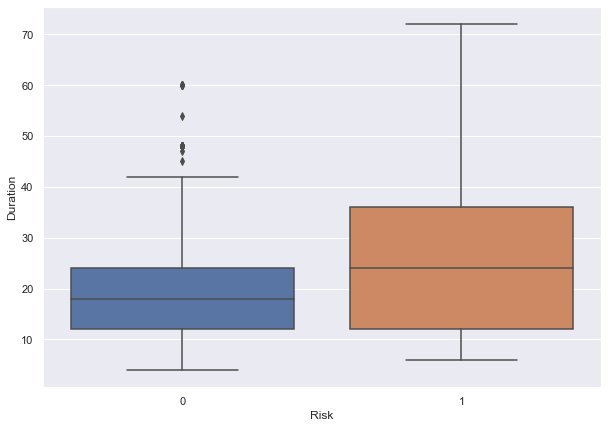

In [27]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Risk", y="Duration", data=data, orient="vertical")
plt.show()

- We can see that second and third quartile duration of defaulters is much more than the second and third quartile duration of non-defaulters.
- This shows that customers with high duration are more likely to default.

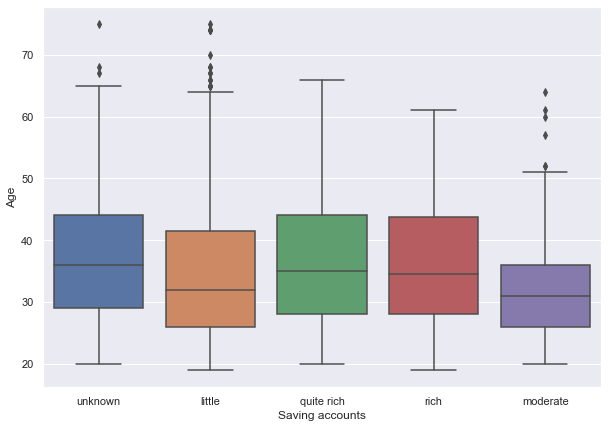

In [28]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Saving accounts", y="Age", data=data)
plt.show()

- The plot shows that customers with higher age are in rich or quite rich category.
- Age of the customers in little and moderate category is slightly less but there are outliers in both of the distributions.

In [29]:
## Function to plot stacked bar chart
def stacked_plot(x):
    sns.set(palette="nipy_spectral")
    tab1 = pd.crosstab(x, data["Risk"], margins=True)
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(x, data["Risk"], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(10, 5))
    # plt.legend(loc='lower left', frameon=False)
    # plt.legend(loc="upper left", bbox_to_anchor=(0,1))
    plt.show()

Risk      0    1   All
Sex                   
female  201  109   310
male    499  191   690
All     700  300  1000
------------------------------------------------------------------------------------------------------------------------


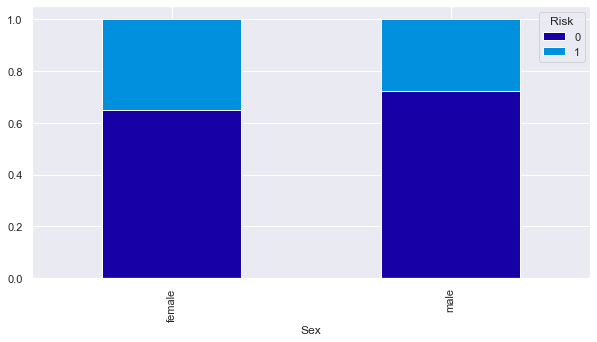

In [30]:
stacked_plot(data["Sex"])

- We saw earlier that the percentage of male customers is more than the female customers. This plot shows that female customers are more likely to default as compared to male customers.

Risk    0    1   All
Job                 
0      15    7    22
1     144   56   200
2     444  186   630
3      97   51   148
All   700  300  1000
------------------------------------------------------------------------------------------------------------------------


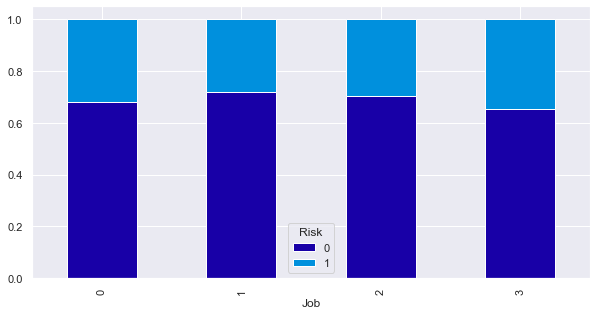

In [31]:
stacked_plot(data["Job"])

- There are no significant difference with respect to the job level
- However, highly skilled or unskilled/non-resident customers are more likely to default as compared to customers in 1 or 2 category 

Risk       0    1   All
Housing                
free      64   44   108
own      527  186   713
rent     109   70   179
All      700  300  1000
------------------------------------------------------------------------------------------------------------------------


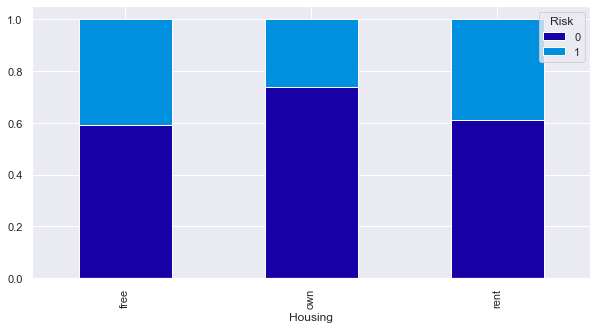

In [32]:
stacked_plot(data['Housing'])

- Customers owning a house are less likely to default
- Customers with free or rented housing are almost at same risk of default

Risk               0    1   All
Saving accounts                
little           386  217   603
moderate          69   34   103
quite rich        52   11    63
rich              42    6    48
unknown          151   32   183
All              700  300  1000
------------------------------------------------------------------------------------------------------------------------


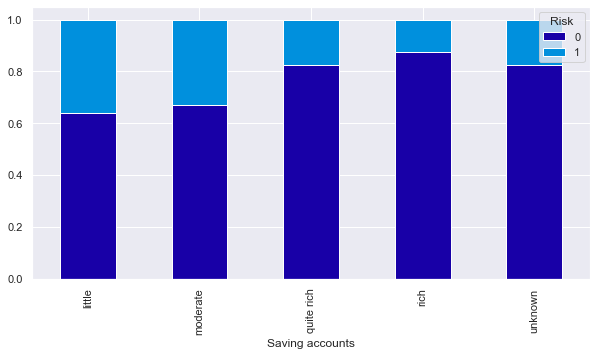

In [33]:
stacked_plot(data["Saving accounts"])

- As we saw earlier, customers with little or moderate amount in saving accounts takes more credit but at the same time they are most likely to default.
- Rich customers are slightly less likely to default as compared to quite rich customers

Risk                0    1   All
Checking account                
little            139  135   274
moderate          164  105   269
rich               49   14    63
unknown           348   46   394
All               700  300  1000
------------------------------------------------------------------------------------------------------------------------


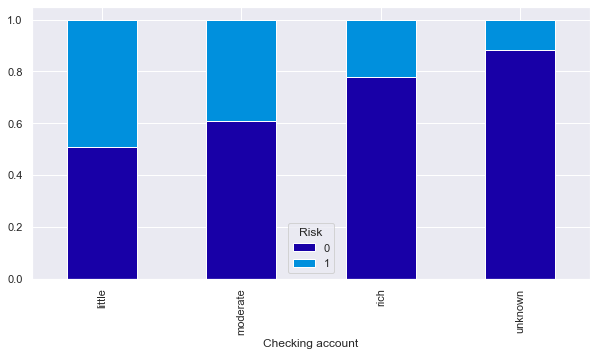

In [34]:
stacked_plot(data['Checking account'])

- The plot further confirms the findings of the plot above.
- Customers with little amount in checking accounts are most likely to default as compared to customers with moderate amount, which in turn, are more likely as compared to the rich customers.

Risk                   0    1   All
Purpose                            
business              63   34    97
car                  231  106   337
domestic appliances    8    4    12
education             36   23    59
furniture/equipment  123   58   181
radio/TV             218   62   280
repairs               14    8    22
vacation/others        7    5    12
All                  700  300  1000
------------------------------------------------------------------------------------------------------------------------


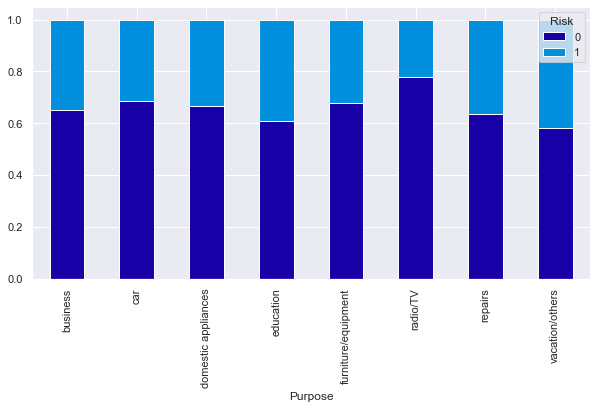

In [35]:
stacked_plot(data["Purpose"])

- Customers who take credit for radio/TV are least likely to default. This might be because their credit amount is small.
- Customers who take credit for education or vacation are most likely to default.
- Other categories have no significant difference between their default and non-default ratio.

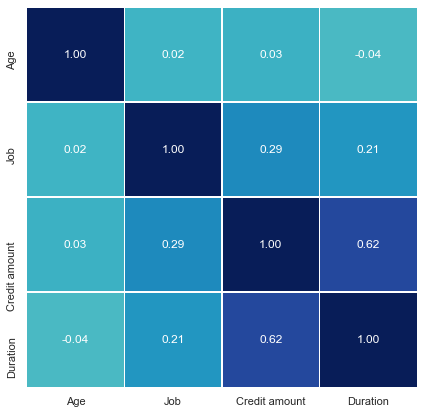

In [36]:
sns.set(rc={"figure.figsize": (7, 7)})
sns.heatmap(
    data.corr(),
    annot=True,
    linewidths=0.5,
    center=0,
    cbar=False,
    cmap="YlGnBu",
    fmt="0.2f",
)
plt.show()

- Credit amount and duration have positive correlation which makes sense as customers might take the credit for longer duration if the amount of credit is high
- Other variables have no significant correlation between them

### Model evaluation criterion

### We will be using Recall as a metric for our model performance, because here company could face 2 types of losses
1. Could Give loan to defaulters - Loss of money
2. Not give Loan to non-defaulters - Loss of opportunity

### Which Loss is greater ? 
* Giving loan to defaulters i.e. False negative i.e Predicting a person not at risk, while in actual person is at risk of making a default 

### How to reduce this loss i.e need to reduce False Negatives ?
* Company wants Recall to be maximized, greater the recall lesser the chances of false negatives

### Data Preparation

* Converting monthly values to yearly, Logistic Regression depends on the scale of the variables so it helps to have variables with similar scale or small scale.

In [37]:
data['Duration'] = data['Duration'] / 12 

* Let's define a function to plot confusion matrix

In [38]:
from sklearn.metrics import classification_report,confusion_matrix


def make_confusion_matrix(y_actual,y_predict,labels=[1, 0]):
    '''
    y_predict: prediction of class
    y_actual : ground truth  
    '''
    cm=confusion_matrix( y_predict,y_actual, labels=[1, 0])
    df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ['1','0']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Split data

In [39]:
X = data.drop('Risk',axis=1) #Dropping continuous 'Age' and 'Credit amount' and keeping the categorical ones we created above
Y = data['Risk']

# creating dummy variables
X = pd.get_dummies(X,drop_first=True)

# splitting in training and test set
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 42)

### Fit logistic regression model  (Statsmodel) 

In [40]:
import statsmodels.api as sm

# adding constant to training and test set
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

logit = sm.Logit( y_train, X_train )

lg = logit.fit()

print(lg.summary2())

# Let's Look at Model Performance
y_pred = lg.predict(X_train) 
pred_train = list(map(round, y_pred))

y_pred1 = lg.predict(X_test) 
pred_test = list(map(round, y_pred1))

print('recall on train data:',recall_score(y_train, pred_train) )
print('recall on test data:',recall_score(y_test, pred_test))

Optimization terminated successfully.
         Current function value: 0.503938
         Iterations 6
                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.173     
Dependent Variable:     Risk                AIC:                 749.5138  
Date:                   2021-05-18 17:56    BIC:                 849.6375  
No. Observations:       700                 Log-Likelihood:      -352.76   
Df Model:               21                  LL-Null:             -426.75   
Df Residuals:           678                 LLR p-value:         4.2196e-21
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         6.0000                                             
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
const            

* The outputs are not reliable, because data might contain multicollinearity - so let's deal with that first

### Check and treat multicollinearity

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_series1 = pd.Series([variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])],index=X_train.columns)
print('Series before feature selection: \n\n{}\n'.format(vif_series1))

Series before feature selection: 

const                          64.399440
Age                             1.187299
Job                             1.140032
Credit amount                   1.973930
Duration                        1.790918
Sex_male                        1.106095
Housing_own                     2.605568
Housing_rent                    2.699594
Saving accounts_moderate        1.114480
Saving accounts_quite rich      1.081380
Saving accounts_rich            1.071061
Saving accounts_unknown         1.141349
Checking account_moderate       1.651880
Checking account_rich           1.209496
Checking account_unknown        1.719470
Purpose_car                     3.340613
Purpose_domestic appliances     1.175755
Purpose_education               1.585808
Purpose_furniture/equipment     2.495637
Purpose_radio/TV                3.084745
Purpose_repairs                 1.263508
Purpose_vacation/others         1.211431
dtype: float64



* None of the variables seems to be correlated, so the values in summary are reliable

* Job has p value = 0.7901, which shows job to be insignificant - this was visible through EDA also
* Credit amount has coefficient = 0.0000  and p value = 0.4144 - again insignificant
* Sex also have p value more than 0.05
* some variables of housing and savings account and checking account are significant, so we won't drop any of these
* Purpose has p value greater than 0.05
* **Let's drop them one by one**

### Drop insignificant variables

In [42]:
#job has highest p values among those with p-value greater than 0.05
X_train1 = X_train.drop('Job', axis =1)
X_test1 = X_test.drop('Job',axis =1)

logit1 = sm.Logit(y_train, X_train1 )
lg1 = logit1.fit()
print(lg1.summary2())

# Let's Look at Model Performance
y_pred = lg1.predict(X_train1) 
pred_train = list(map(round, y_pred))

y_pred1 = lg1.predict(X_test1) 
pred_test = list(map(round, y_pred1))

print('Recall on train data:',recall_score(y_train, pred_train) )
print('Recall on test data:',recall_score(y_test, pred_test))

Optimization terminated successfully.
         Current function value: 0.503989
         Iterations 6
                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.173     
Dependent Variable:     Risk                AIC:                 747.5847  
Date:                   2021-05-18 17:56    BIC:                 843.1574  
No. Observations:       700                 Log-Likelihood:      -352.79   
Df Model:               20                  LL-Null:             -426.75   
Df Residuals:           679                 LLR p-value:         1.5686e-21
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         6.0000                                             
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
const            

* Not much change in recall, let's drop Purpose now

In [43]:
#purpose has highest p values among those with p-value greater than 0.05
X_train2 = X_train1.drop(['Purpose_car','Purpose_domestic appliances','Purpose_education','Purpose_furniture/equipment','Purpose_radio/TV','Purpose_repairs','Purpose_vacation/others'], axis =1)
X_test2 = X_test1.drop(['Purpose_car','Purpose_domestic appliances','Purpose_education','Purpose_furniture/equipment','Purpose_radio/TV','Purpose_repairs','Purpose_vacation/others'],axis =1)

logit2 = sm.Logit(y_train, X_train2 )
lg2 = logit2.fit()
print(lg2.summary2())

# Let's Look at Model Performance
y_pred = lg2.predict(X_train2) 
pred_train = list(map(round, y_pred))

y_pred1 = lg2.predict(X_test2) 
pred_test = list(map(round, y_pred1))

print('recall on train data:',recall_score(y_train, pred_train) )
print('recall on test data:',recall_score(y_test, pred_test))

Optimization terminated successfully.
         Current function value: 0.511058
         Iterations 6
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.162     
Dependent Variable:    Risk                AIC:                 743.4807  
Date:                  2021-05-18 17:56    BIC:                 807.1959  
No. Observations:      700                 Log-Likelihood:      -357.74   
Df Model:              13                  LL-Null:             -426.75   
Df Residuals:          686                 LLR p-value:         5.2246e-23
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        6.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
const                       

* no much change in recall

In [44]:
#Credit amount has highest p values among those with p-value greater than 0.05
X_train3 = X_train2.drop('Credit amount', axis =1)
X_test3 = X_test2.drop('Credit amount',axis =1)

logit3 = sm.Logit(y_train, X_train3 )
lg3 = logit3.fit()
print(lg3.summary2())

# Let's Look at Model Performance
y_pred = lg3.predict(X_train3) 
pred_train = list(map(round, y_pred))

y_pred1 = lg3.predict(X_test3) 
pred_test = list(map(round, y_pred1))

print('recall on train data:',recall_score(y_train, pred_train) )
print('recall on test data:',recall_score(y_test, pred_test))

Optimization terminated successfully.
         Current function value: 0.512003
         Iterations 6
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.160     
Dependent Variable:    Risk                AIC:                 742.8047  
Date:                  2021-05-18 17:56    BIC:                 801.9688  
No. Observations:      700                 Log-Likelihood:      -358.40   
Df Model:              12                  LL-Null:             -426.75   
Df Residuals:          687                 LLR p-value:         2.7680e-23
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        6.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
const                       

* recall on train increased from .40 to .43 and on test fom .36 to .37 - Now let's drop Sex_male

In [45]:
#Sex_male has highest p values among those with p-value greater than 0.05
X_train4 = X_train3.drop('Sex_male', axis =1)
X_test4 = X_test3.drop('Sex_male',axis =1)

logit4 = sm.Logit(y_train, X_train4 )
lg4 = logit4.fit()
print(lg4.summary2())

# Let's Look at Model Performance
y_pred = lg4.predict(X_train4) 
pred_train = list(map(round, y_pred))

y_pred1 = lg4.predict(X_test4) 
pred_test = list(map(round, y_pred1))

print('recall on train data:',recall_score(y_train, pred_train) )
print('recall on test data:',recall_score(y_test, pred_test))

Optimization terminated successfully.
         Current function value: 0.514322
         Iterations 6
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.156     
Dependent Variable:    Risk                AIC:                 744.0502  
Date:                  2021-05-18 17:56    BIC:                 798.6632  
No. Observations:      700                 Log-Likelihood:      -360.03   
Df Model:              11                  LL-Null:             -426.75   
Df Residuals:          688                 LLR p-value:         3.4696e-23
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        6.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
const                       

* recall on train is same 
* So lg4 is the final model that we will use for predictions and inferences

### Let's use model 'lg4' for making interpretations
* As per lg4, Age, Duration, Housing, Savings accounts, checking accounts are important variables here
* All variables except Duration have negative signs, i.e increase in these will lead to decrease in chances of default
* 1 unit increase in Age decreases the odds of being defaulter by 3.03%
* This relates to changes in probability by .75
* Similarly for all the other variables

* Please note that when coefficient is b , than change in odds is (exp(b)-1)*100 %
* Probability = odd/(1+odd)


### Check Model Performance

In [46]:
# Let's Look at Model Performance
y_pred = lg4.predict(X_train4) 
pred_train = list(map(round, y_pred))

y_pred1 = lg4.predict(X_test4) 
pred_test = list(map(round, y_pred1))

In [47]:
#Model performance with 0.5 threshold

print('Accuracy on train data:',accuracy_score(y_train, pred_train) )
print('Accuracy on test data:',accuracy_score(y_test, pred_test))

print('Recall on train data:',recall_score(y_train, pred_train) )
print('Recall on test data:',recall_score(y_test, pred_test))

print('Precision on train data:',precision_score(y_train, pred_train) )
print('Precision on test data:',precision_score(y_test, pred_test))

print('f1 score on train data:',f1_score(y_train, pred_train))
print('f1 score on test data:',f1_score(y_test, pred_test))

Accuracy on train data: 0.7614285714285715
Accuracy on test data: 0.7333333333333333
Recall on train data: 0.40669856459330145
Recall on test data: 0.3626373626373626
Precision on train data: 0.6640625
Precision on test data: 0.6
f1 score on train data: 0.5044510385756676
f1 score on test data: 0.4520547945205479


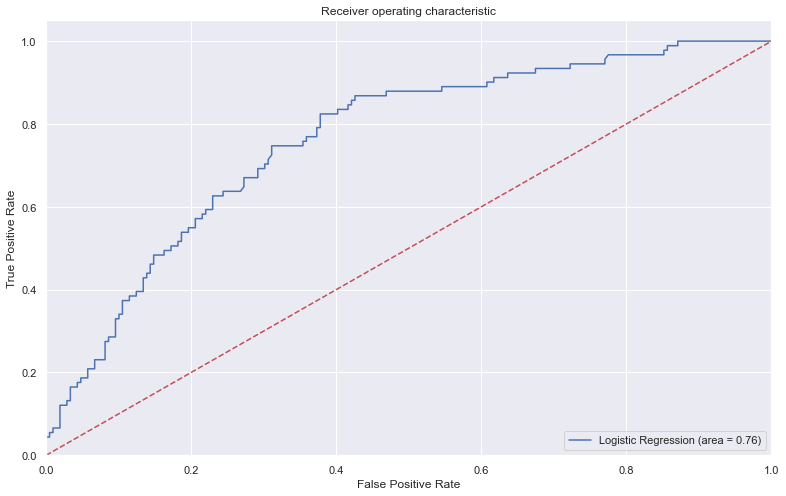

In [48]:
#AUC ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, lg4.predict(X_test4))
fpr, tpr, thresholds = roc_curve(y_test, lg4.predict(X_test4))
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Try to improve Recall using AUC-ROC curve

In [49]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# Optimal threshold as per AUC-ROC curve
# The optimal cut off would be where tpr is high and fpr is low
fpr, tpr, thresholds = roc_curve(y_test, lg4.predict(X_test4))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

0.2379202144265259


In [50]:
# Model prediction with optimal threshold
pred_train_opt = (lg.predict(X_train)>optimal_threshold).astype(int)
pred_test_opt = (lg.predict(X_test)>optimal_threshold).astype(int)

In [51]:
#Model performance with optimal threhold

print('Accuracy on train data:',accuracy_score(y_train, pred_train_opt) )
print('Accuracy on test data:',accuracy_score(y_test, pred_test_opt))

print('Recall on train data:',recall_score(y_train, pred_train_opt))
print('Recall on test data:',recall_score(y_test, pred_test_opt))

print('Precision on train data:',precision_score(y_train, pred_train_opt) )
print('Precision on test data:',precision_score(y_test, pred_test_opt))

print('f1 score on train data:',f1_score(y_train, pred_train_opt))
print('f1 score on test data:',f1_score(y_test, pred_test_opt))

Accuracy on train data: 0.6728571428571428
Accuracy on test data: 0.6733333333333333
Recall on train data: 0.8373205741626795
Recall on test data: 0.8021978021978022
Precision on train data: 0.47297297297297297
Precision on test data: 0.477124183006536
f1 score on train data: 0.6044905008635578
f1 score on test data: 0.5983606557377049


* Recall has improved to quite good extent.

### Now Let's use Precision-Recall curve and see if we can find a better threshold

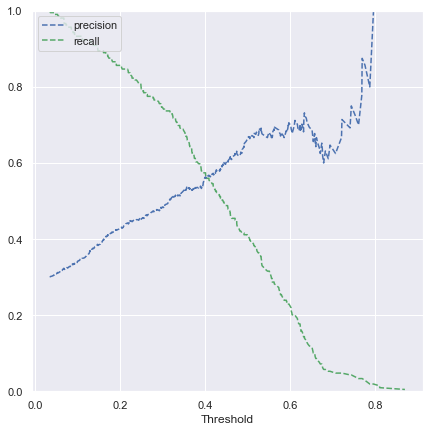

In [52]:
from sklearn.metrics import precision_recall_curve

y_scores=lg4.predict(X_train4)
prec, rec, tre = precision_recall_curve(y_train, y_scores, )

def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

* Decreasing threshold beyond 0.3 will lead to fast decrease in Precision, which will lead to great loss of opportunity, so let's consider threshold of 0.3

### Check Model Performance

In [53]:
optimal_threshold = 0.3

# Model prediction with optimal threshold
pred_train_opt = (lg.predict(X_train)>optimal_threshold).astype(int)
pred_test_opt = (lg.predict(X_test)>optimal_threshold).astype(int)

#Model performance with optimal threhold

print('Accuracy on train data:',accuracy_score(y_train, pred_train_opt) )
print('Accuracy on test data:',accuracy_score(y_test, pred_test_opt))

print('Recall on train data:',recall_score(y_train, pred_train_opt))
print('Recall on test data:',recall_score(y_test, pred_test_opt))

print('Precision on train data:',precision_score(y_train, pred_train_opt) )
print('Precision on test data:',precision_score(y_test, pred_test_opt))

print('f1 score on train data:',f1_score(y_train, pred_train_opt))
print('f1 score on test data:',f1_score(y_test, pred_test_opt))

Accuracy on train data: 0.7071428571428572
Accuracy on test data: 0.7
Recall on train data: 0.7416267942583732
Recall on test data: 0.6593406593406593
Precision on train data: 0.5065359477124183
Precision on test data: 0.5042016806722689
f1 score on train data: 0.6019417475728155
f1 score on test data: 0.5714285714285715


* The previous model was better in terms of metrics, where we chose optimal threshold using AUC-ROC curve

In [54]:
from sklearn.metrics import classification_report,confusion_matrix


def make_confusion_matrix(y_actual,y_predict,labels=[1, 0]):
    '''
    y_predict: prediction of class
    y_actual : ground truth  
    '''
    cm=confusion_matrix( y_predict,y_actual, labels=[1, 0])
    df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ['1','0']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

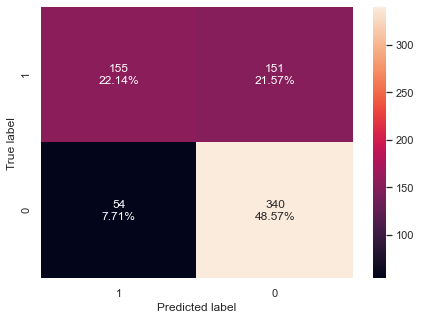

In [55]:
# let us make confusion matrix on train set
make_confusion_matrix(y_train,pred_train_opt)

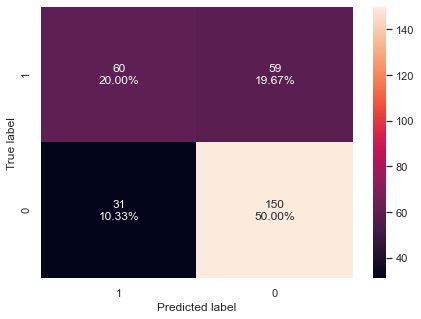

In [56]:
# let us make confusion matrix on test set
make_confusion_matrix(y_test,pred_test_opt)

## Conclusion and Recommendations

- The best test recall in 80% but the test precision is quiet low i.e ~47% at the same time. This means that the model is not good at identifying non-defaulter, therefore, bank can lose many opportunities of giving credit to non-defaulters.   
- The model performance can be improved, especially in terms of precision and the bank can use use the model for new customers once desired level of model performance is achieved.
- We saw our analysis that customers with little or moderate amount in saving or checking account are more likely to default. 
The bank can be more strict with their rules or interest rates to compensate for the risk.
- We saw that customers who have rented or free housing are more likely to default. The bank should keep more details about such customers like hometown address, etc. to be able to track them.
- Our analysis showed that, younger customers are slightly more likely to default. The bank can alter their policies to suppress this.